In [147]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [148]:
import h2o
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd
from h2o.estimators.kmeans import H2OKMeansEstimator


def determine_centers(data, **params):
    print('Inputs:')
    print(data.columns.values)

    training_frame = h2o.H2OFrame(data.values)
    training_frame.set_names(data.columns.values.tolist())

    columns = training_frame.columns

    h2o_km = H2OKMeansEstimator(**params)
    h2o_km.train(x=columns, training_frame=training_frame)

    return h2o_km

h2o.init(ip="local.h2o.air_data", port=54321)

Checking whether there is an H2O instance running at http://local.h2o.air_data:54321. connected.


H2O cluster uptime:,2 days 2 hours 13 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,2 months and 17 days
H2O cluster name:,root
H2O cluster total nodes:,1
H2O cluster free memory:,10.27 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


# K-means
http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2okmeansestimator

In [149]:
from src import repository_adapter

training_dataset = repository_adapter.run_sql(
    """ SELECT
        AVG(result) as average,
        SUM(result) as sum,
        MIN(result) as min,
        MAX(result) as max,
        metering_point_id        
        FROM air.air_quality_measures am
        WHERE result IS NOT NULL
        GROUP BY metering_point_id
        #, YEAR(date);
            
        ;""",
    [
        "average", 
        "sum", 
        "min",         
        "max", 
        "metering_point_id", 
    ]
)

training_dataset['average'] = training_dataset['average'].map(lambda x: float(x))
training_dataset['sum'] = training_dataset['sum'].map(lambda x: float(x))
training_dataset['max'] = training_dataset['max'].map(lambda x: float(x))
training_dataset['min'] = training_dataset['min'].map(lambda x: float(x))

dataset = training_dataset.drop(columns=['metering_point_id','min'])
model = determine_centers(dataset, 
    k = 20, 
    estimate_k = True,
    standardize = False
)

summary = model.summary().as_data_frame()

print('Number of clusters')
print(summary['number_of_clusters'])
print(model.centers())



Inputs:
['average' 'sum' 'max']
Parse progress: |█████████████████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
Number of clusters
0    3.0
Name: number_of_clusters, dtype: float64
[[19.71300428, 230376.5, 297.3], [21.747800873913047, 492178.0, 265.4782608695652], [28.00197614375, 713334.9375, 418.8125]]


<IPython.core.display.Javascript object>


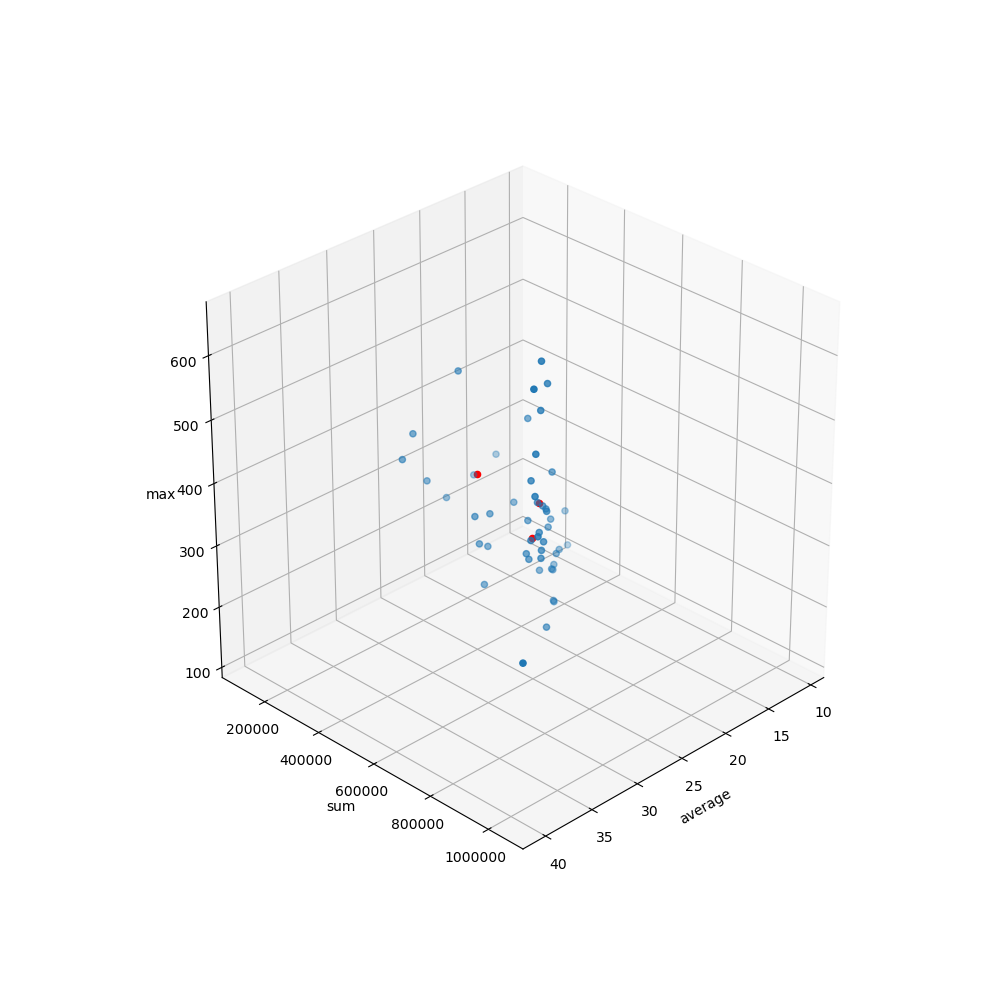

In [150]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


# 3D PLOT
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)
ax.set_xlabel('average')
ax.set_ylabel('sum')
ax.set_zlabel('max')


ax.scatter(
    training_dataset['average'], 
    training_dataset['sum'], 
    training_dataset['max'], 

    cmap='rainbow'
)

for x, y, z in model.centers():
    ax.scatter(
        x, 
        y, 
        z, 
        c='r'
    )


ax.view_init(30, 45)
plt.show()

# Hierarchical clustering (agglomerative)
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [151]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import numpy as np
import pandas as pd

from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering


def min_max_scale(data):
    scaler = StandardScaler(with_mean=True)
    scaler.fit(data)
    data = scaler.transform(data)
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data)
    return scaler.transform(data)


def scale_data(data):
    for column in data:
        data[column] = min_max_scale(data[column].values.reshape(-1, 1))
    return data


def get_from_cluster(label_index, cluster_results_dict):
    filtered_result = dict(filter(lambda x: x[1] == label_index, cluster_results_dict.items()))
    return filtered_result.keys()


def determine_centers(k, customers, data):
    
#     data_values = min_max_scale(data.values)
    data_values = data.values    
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
    model.fit_predict(data_values)
    

    return model

    
    
data = training_dataset.drop(columns=['metering_point_id','min'])
metering_point_ids = training_dataset['metering_point_id'].values

# for k in range(10):
#     model = determine_centers(
#         k+2,
#         metering_point_ids, 
#         data
#     )
    
#     score = metrics.silhouette_score(data.values, model.labels_)
#     plt.plot(k+2, score, 'ro',color="red", )

# plt.show()



model = determine_centers(
    5,
    metering_point_ids, 
    data
)

metering_point_clusters = dict(zip(metering_point_ids, model.labels_))
print(metering_point_clusters)





{1: 4, 2: 0, 3: 4, 4: 4, 5: 2, 6: 1, 7: 0, 8: 2, 9: 4, 10: 2, 11: 2, 12: 3, 13: 0, 14: 0, 15: 1, 16: 1, 17: 0, 18: 1, 19: 0, 20: 4, 21: 0, 22: 0, 23: 0, 24: 2, 25: 2, 26: 4, 27: 0, 28: 0, 29: 1, 30: 2, 31: 1, 32: 1, 33: 1, 34: 2, 35: 4, 36: 1, 37: 1, 38: 2, 39: 0, 40: 2, 41: 4, 42: 0, 43: 0, 44: 2, 45: 2, 46: 0, 47: 4, 48: 2, 49: 2}
